In [445]:
import run_hp_tuning
import pandas as pd
import numpy as np

In [471]:
import sqlite3
conn = sqlite3.connect("results/optuna_results.db")
print(pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table'", conn))
data_merged = pd.read_sql_query("SELECT * FROM trial_values val LEFT JOIN trial_params par on val.trial_id = par.trial_id", conn)

                         name
0                     studies
1                version_info
2            study_directions
3       study_user_attributes
4     study_system_attributes
5                      trials
6       trial_user_attributes
7     trial_system_attributes
8                trial_params
9                trial_values
10  trial_intermediate_values
11           trial_heartbeats
12            alembic_version


In [472]:
data = pd.read_sql_query("SELECT tr.trial_id, sd.study_name, val.value FROM trials tr LEFT JOIN studies sd on tr.study_id = sd.study_id LEFT JOIN trial_values val on val.trial_id = tr.trial_id", conn)

In [478]:
data.groupby("study_name").aggregate({"value": np.max}).sort_values("value", ascending=False)

/var/folders/m4/j_mwks0x04ncx2w9srg4t8qh0000gn/T/ipykernel_2772/2968359179.py:1: FutureWarning: The provided callable <function max at 0x104e05e40> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  data.groupby("study_name").aggregate({"value": np.max}).sort_values("value", ascending=False)


,value
study_name,
Volatility_Breakout_Double_Strategy_XAG,17.748904
Volatility_Breakout_Strategy_NQ,14.555338
Volatility_Breakout_Strategy_SP,12.755870
Volatility_Breakout_Double_Strategy_SP,10.823092
Volatility_Breakout_Double_Strategy_NQ,10.777073
Volatility_Breakout_Double_Strategy_XAU,4.820738
Moving_Average_Strategy_SP,1.303133
Volatility_Breakout_Strategy_XAG,1.117666
Moving_Average_Strategy_NQ,0.864684


In [479]:
def process_results(data, group = 1):
    group_cols = [x for x in data.columns if x not in ['selected_quarter','stats_mm','stats_mr','stats_fl']]
    df = (
        data.replace(np.inf, 0)
        .groupby(group_cols)
        .aggregate({
            "stats_mm": [np.mean, np.std],
            "stats_mr": [np.mean, np.std],
            "stats_fl": [np.mean, np.std]
        })
        .query(f"group_data == {group}")
    )
    df.columns = ['_'.join(col).strip() for col in df.columns]
    df["stats_mm_mean_corr"] = df["stats_mm_mean"] - df["stats_mm_std"]/2
    df["stats_mr_mean_corr"] = df["stats_mr_mean"] - df["stats_mr_std"]/2
    df["stats_fl_mean_corr"] = df["stats_fl_mean"] - df["stats_fl_std"]/2

    df['max_mean_stats'] = df[['stats_mm_mean', 'stats_mr_mean', 'stats_fl_mean']].max(axis=1)
    df['max_mean_stats_corr'] = df[['stats_mm_mean_corr', 'stats_mr_mean_corr', 'stats_fl_mean_corr']].max(axis=1)
    return df.sort_values("max_mean_stats_corr", ascending=False)

In [480]:
vb2_results = pd.read_csv("results/Volatility_Breakout_Double_Strategy/results.csv")
vb_results = pd.read_csv("results/Volatility_Breakout_Strategy/results.csv")
ma_results = pd.read_csv("results/Moving_Average_Strategy/results.csv")

In [481]:
vb2_gr1 = process_results(vb2_results,1)
vb2_gr2 = process_results(vb2_results,2)

vb_gr1 = process_results(vb_results,1)
vb_gr2 = process_results(vb_results,2)

ma_gr1 = process_results(ma_results,1)
ma_gr2 = process_results(ma_results,2)

/var/folders/m4/j_mwks0x04ncx2w9srg4t8qh0000gn/T/ipykernel_2772/3746787947.py:6: FutureWarning: The provided callable <function mean at 0x104e06840> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  .aggregate({
/var/folders/m4/j_mwks0x04ncx2w9srg4t8qh0000gn/T/ipykernel_2772/3746787947.py:6: FutureWarning: The provided callable <function std at 0x104e06980> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  .aggregate({
/var/folders/m4/j_mwks0x04ncx2w9srg4t8qh0000gn/T/ipykernel_2772/3746787947.py:6: FutureWarning: The provided callable <function mean at 0x104e06840> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  .aggrega

In [482]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

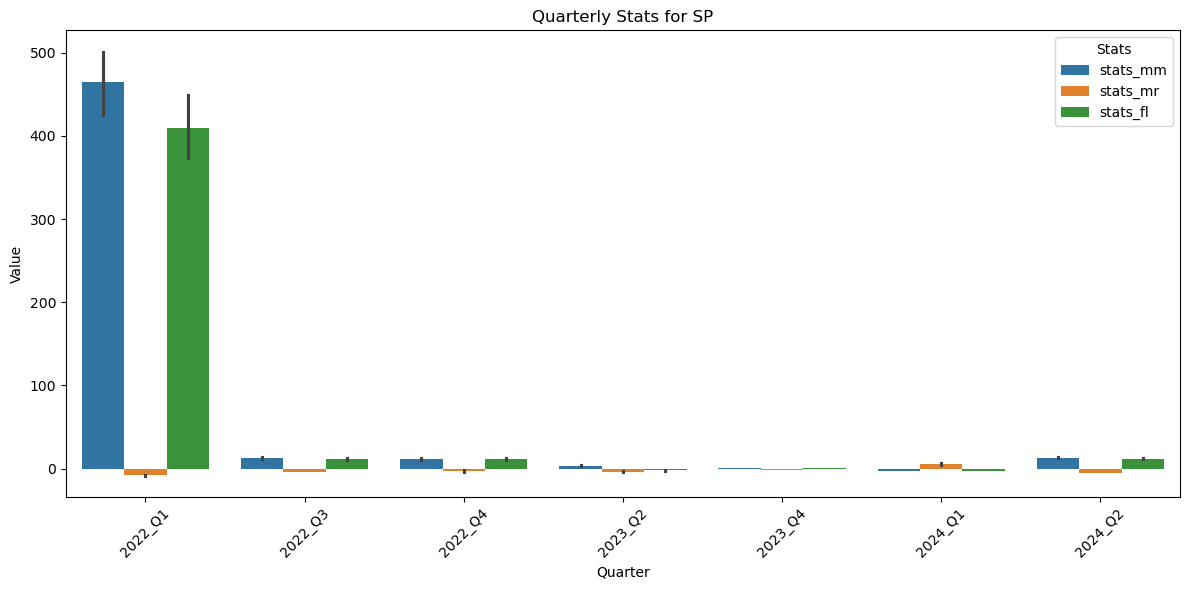

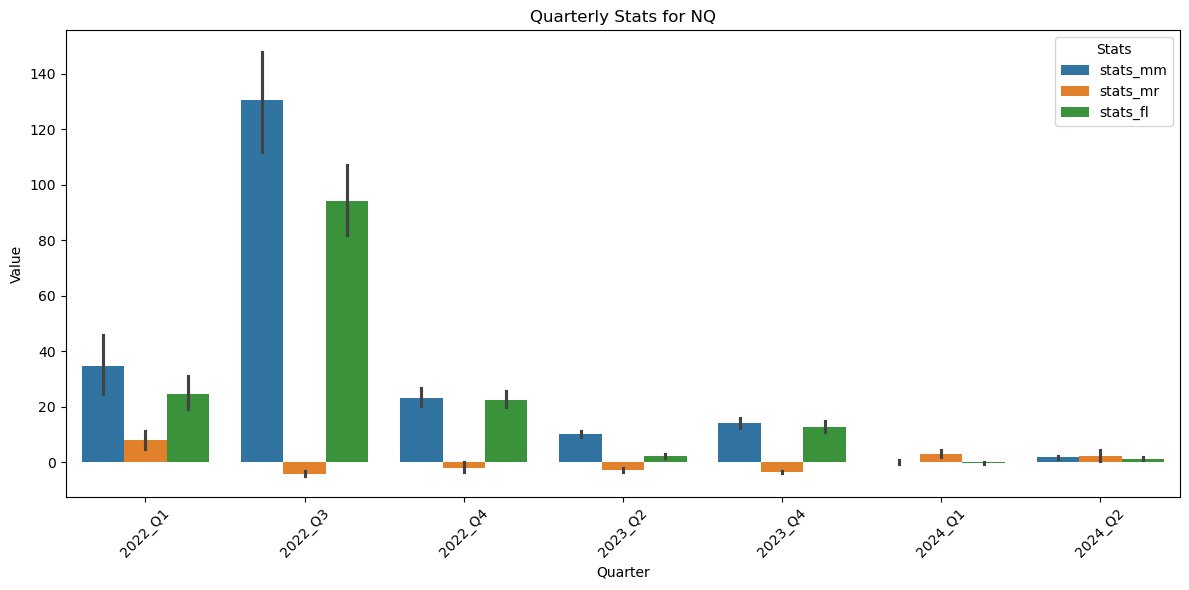

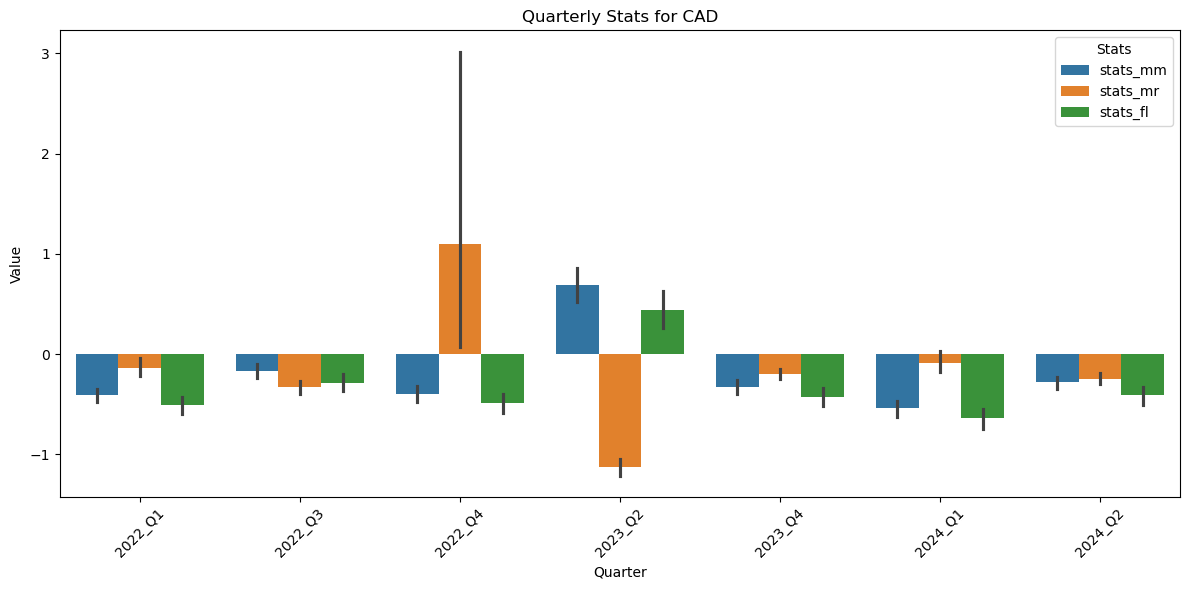

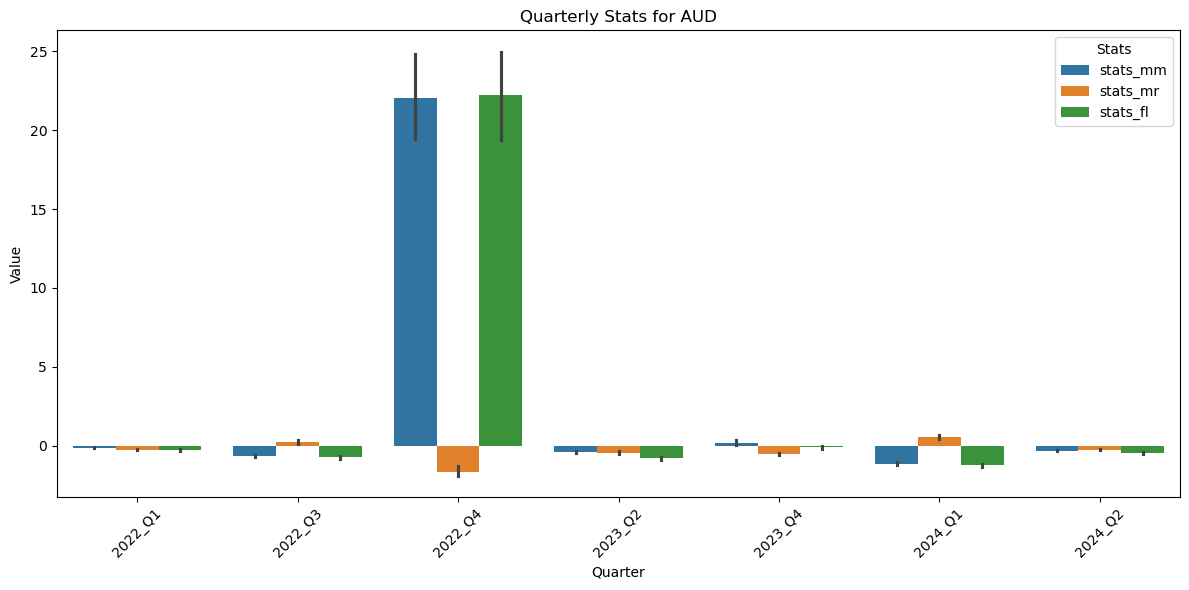

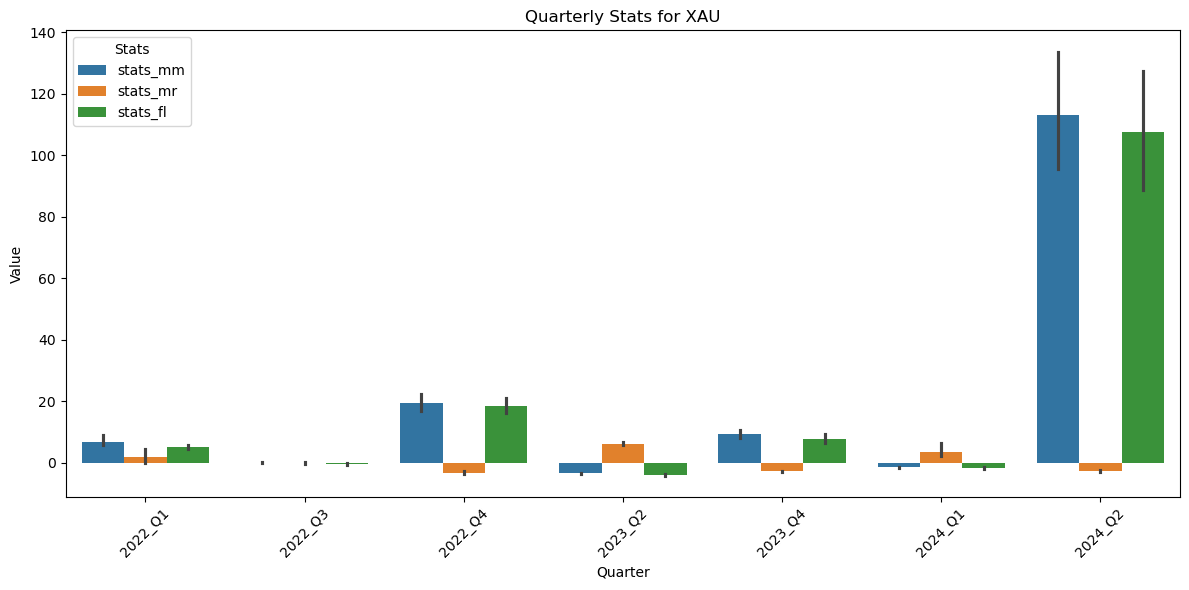

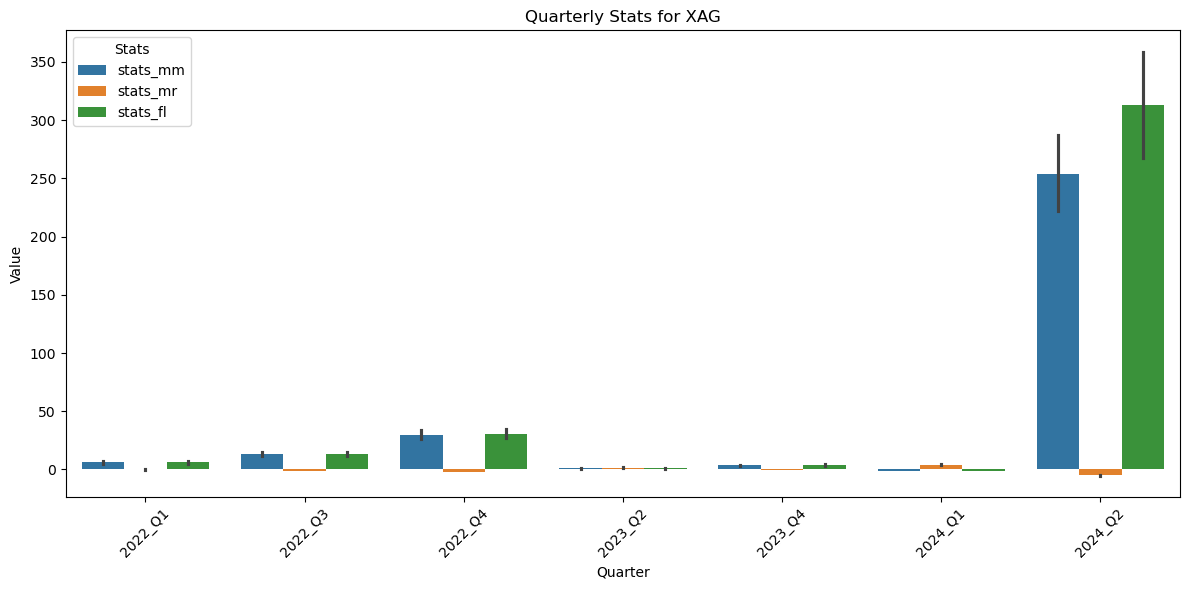

In [483]:
df = vb2_results
for instrument in df['instrument_name'].unique():
    # Filter data for the current instrument
    data = df.query(f"instrument_name == '{instrument}'")

    # Melt the DataFrame to convert stats columns into rows for grouped barplot
    melted_data = data.melt(
        id_vars=["selected_quarter"],
        value_vars=["stats_mm", "stats_mr", "stats_fl"],
        var_name="Stat",
        value_name="Value"
    )

    # Set up the plot
    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=melted_data,
        x="selected_quarter",
        y="Value",
        hue="Stat",
        # ci=None
    )

    # Add plot details
    plt.title(f"Quarterly Stats for {instrument}")
    plt.xlabel("Quarter")
    plt.ylabel("Value")
    plt.legend(title="Stats")
    plt.xticks(rotation=45)

    # Show plot
    plt.tight_layout()
    plt.show()


# 2VB

## GR1

In [484]:
df = vb2_gr1.query("instrument_name == 'NQ' and max_mean_stats>100")
params = {x:y for x,y in df.reset_index().to_dict(orient="records")[0].items() if "stat" not in x}
query_conditions = []
for key, value in params.items():
    if isinstance(value, int):
        query_conditions.append(f"{key} == {value}")
    elif isinstance(value, float):
        query_conditions.append(f"{key} == {round(value, 5)}")
    elif isinstance(value, str):
        query_conditions.append(f"{key} == '{value}'")
query = " and ".join(query_conditions)
vb2_results.query(query)

,selected_quarter,fast_ma,ma_diff,signal_estimator,window_regime,treshold_regime,volat_param,m_exit,m_diff,instrument_name,group_data,p_val,tr_cost,stats_mm,stats_mr,stats_fl
29183,2022_Q1,67,80,mean,37,0.02027,87,2.19893,0.69793,NQ,1,20,12,0.177070,-0.760198,0.177070
29184,2022_Q3,67,80,mean,37,0.02027,87,2.19893,0.69793,NQ,1,20,12,928.291021,-9.852259,928.291021
29185,2022_Q4,67,80,mean,37,0.02027,87,2.19893,0.69793,NQ,1,20,12,188.213417,-6.657930,684.233186
29186,2023_Q2,67,80,mean,37,0.02027,87,2.19893,0.69793,NQ,1,20,12,6.993013,-5.389639,0.007935
29187,2023_Q4,67,80,mean,37,0.02027,87,2.19893,0.69793,NQ,1,20,12,14.278839,-6.943797,14.278839
29188,2024_Q1,67,80,mean,37,0.02027,87,2.19893,0.69793,NQ,1,20,12,-1.251067,1.198764,-1.186973
29189,2024_Q2,67,80,mean,37,0.02027,87,2.19893,0.69793,NQ,1,20,12,-5.768903,17.015032,-5.655316


In [485]:
import seaborn as sns

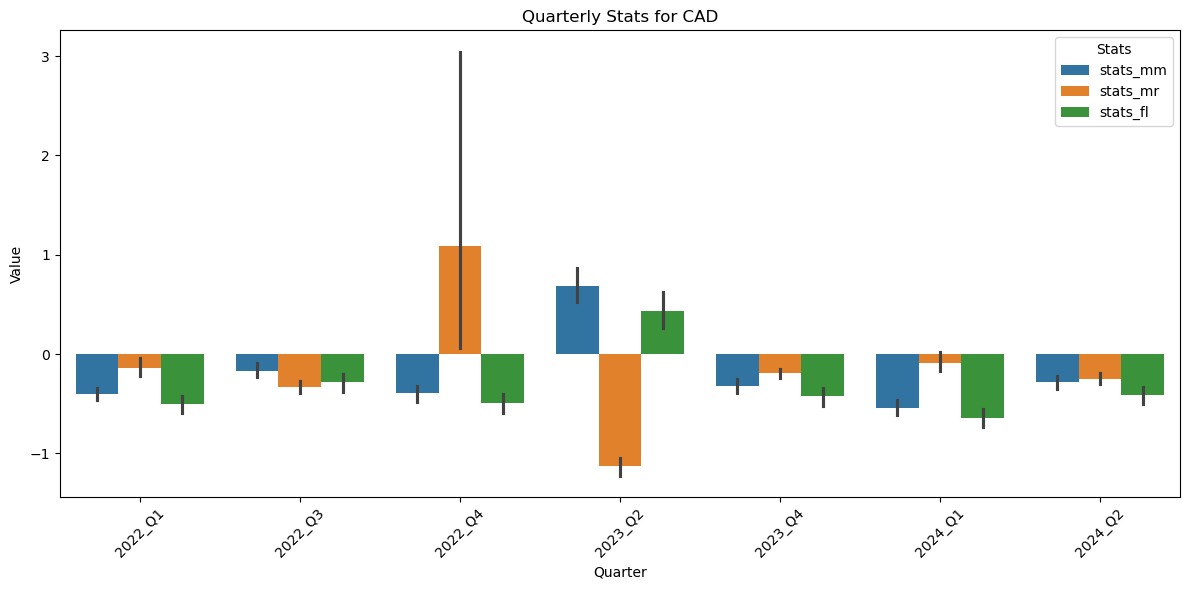

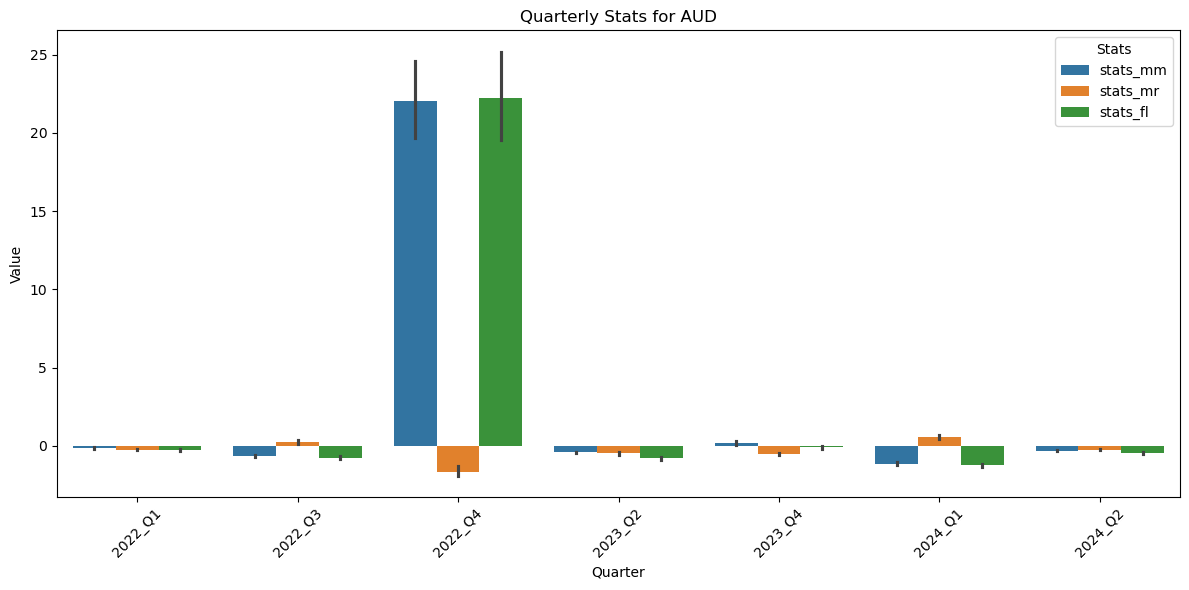

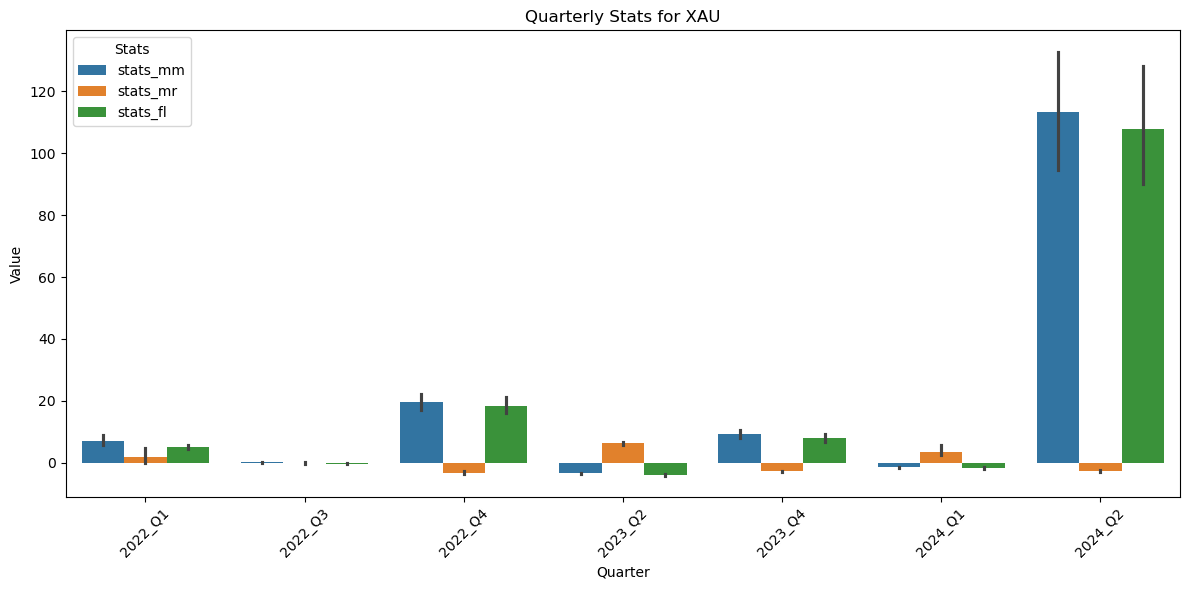

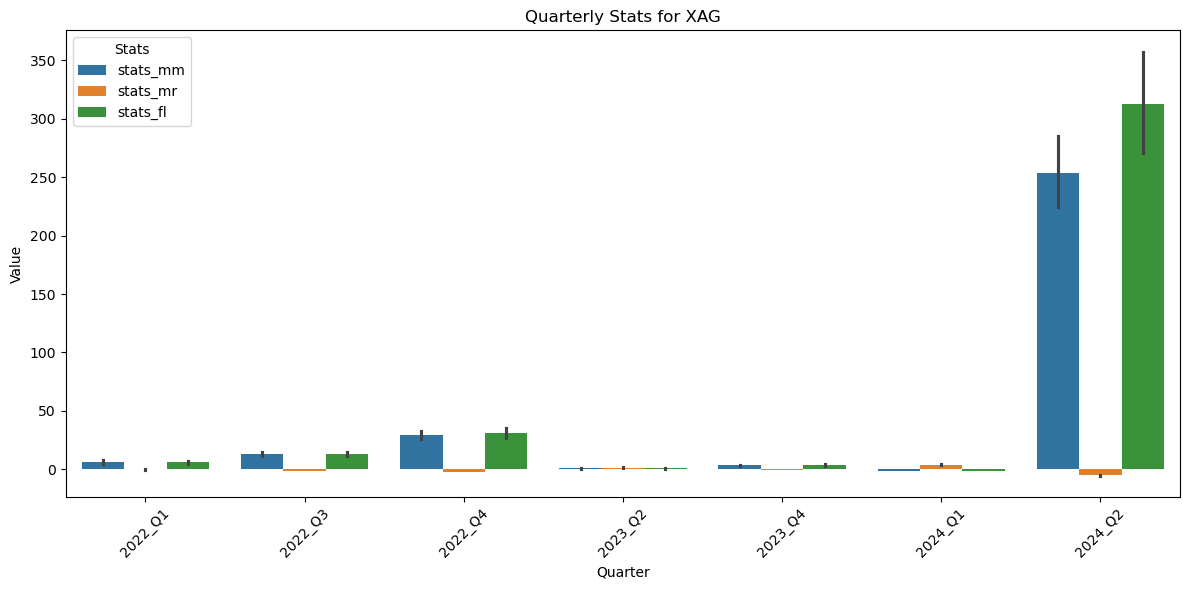

In [499]:
df = vb2_results.query("group_data==2")
for instrument in df['instrument_name'].unique():
    # Filter data for the current instrument
    data = df.query(f"instrument_name == '{instrument}'")

    # Melt the DataFrame to convert stats columns into rows for grouped barplot
    melted_data = data.melt(
        id_vars=["selected_quarter"],
        value_vars=["stats_mm", "stats_mr", "stats_fl"],
        var_name="Stat",
        value_name="Value"
    )

    # Set up the plot
    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=melted_data,
        x="selected_quarter",
        y="Value",
        hue="Stat",
        # ci=None
    )

    # Add plot details
    plt.title(f"Quarterly Stats for {instrument}")
    plt.xlabel("Quarter")
    plt.ylabel("Value")
    plt.legend(title="Stats")
    plt.xticks(rotation=45)

    # Show plot
    plt.tight_layout()
    plt.show()


In [487]:
vb2_gr1.groupby("instrument_name").max()

,stats_mm_mean,stats_mm_std,stats_mr_mean,stats_mr_std,stats_fl_mean,stats_fl_std,stats_mm_mean_corr,stats_mr_mean_corr,stats_fl_mean_corr,max_mean_stats,max_mean_stats_corr
instrument_name,,,,,,,,,,,
NQ,526.499385,1360.001595,170.176905,438.465720,451.040624,1185.640283,28.389818,4.517224,31.954739,526.499385,31.954739
SP,722.677770,1899.044794,217.192406,577.147936,882.727596,2330.138762,20.359126,0.000000,18.918063,882.727596,20.359126


In [488]:
df = vb2_gr1.sort_values("max_mean_stats", ascending=False).head(3)
params = {x:y for x,y in df.reset_index().to_dict(orient="records")[2].items() if "stat" not in x}
query_conditions = []
for key, value in params.items():
    if isinstance(value, int):
        query_conditions.append(f"{key} == {value}")
    elif isinstance(value, float):
        query_conditions.append(f"{key} == {round(value, 5)}")
    elif isinstance(value, str):
        query_conditions.append(f"{key} == '{value}'")
query = " and ".join(query_conditions)
vb2_results.query(query)

,selected_quarter,fast_ma,ma_diff,signal_estimator,window_regime,treshold_regime,volat_param,m_exit,m_diff,instrument_name,group_data,p_val,tr_cost,stats_mm,stats_mr,stats_fl
9429,2022_Q1,72,60,median,51,0.19115,60,2.65975,1.44789,SP,1,50,12,3342.244294,-8.932690,5813.578176
9430,2022_Q3,72,60,median,51,0.19115,60,2.65975,1.44789,SP,1,50,12,0.000000,0.000000,0.000000
9431,2022_Q4,72,60,median,51,0.19115,60,2.65975,1.44789,SP,1,50,12,0.000000,0.000000,0.000000
9432,2023_Q2,72,60,median,51,0.19115,60,2.65975,1.44789,SP,1,50,12,-0.780867,-0.665822,-3.707271
9433,2023_Q4,72,60,median,51,0.19115,60,2.65975,1.44789,SP,1,50,12,0.000000,0.000000,0.000000
9434,2024_Q1,72,60,median,51,0.19115,60,2.65975,1.44789,SP,1,50,12,-4.306643,9.273283,-4.433946
9435,2024_Q2,72,60,median,51,0.19115,60,2.65975,1.44789,SP,1,50,12,15.443793,-4.665035,14.341258


In [489]:
vb2_gr1.sort_values("max_mean_stats", ascending=False).head(3)

,,,,,,,,,,,,stats_mm_mean,stats_mm_std,stats_mr_mean,stats_mr_std,stats_fl_mean,stats_fl_std,stats_mm_mean_corr,stats_mr_mean_corr,stats_fl_mean_corr,max_mean_stats,max_mean_stats_corr
fast_ma,ma_diff,signal_estimator,window_regime,treshold_regime,volat_param,m_exit,m_diff,instrument_name,group_data,p_val,tr_cost,,,,,,,,,,,
72,62,median,48,0.16716,61,2.70505,1.36318,SP,1,50,12,508.769293,1339.316259,-1.467694,5.918443,882.727596,2330.138762,-160.888836,-4.426915,-282.341785,882.727596,-4.426915
70,62,median,48,0.13832,60,2.70040,1.48849,SP,1,50,12,498.479595,1313.974397,-0.979074,5.364426,865.289641,2286.013101,-158.507604,-3.661287,-277.716910,865.289641,-3.661287
72,60,median,51,0.19115,60,2.65975,1.44789,SP,1,50,12,478.942940,1262.613045,-0.712895,5.544292,831.396888,2196.944271,-152.363583,-3.485041,-267.075247,831.396888,-3.485041


In [490]:
vb_gr1.groupby("instrument_name").max()

,stats_mm_mean,stats_mm_std,stats_mr_mean,stats_mr_std,stats_fl_mean,stats_fl_std,stats_mm_mean_corr,stats_mr_mean_corr,stats_fl_mean_corr,max_mean_stats,max_mean_stats_corr
instrument_name,,,,,,,,,,,
NQ,545.941031,1317.241286,274.972552,649.038794,621.573528,1530.269012,37.715868,4.563198,65.296689,621.573528,65.296689
SP,190.617118,483.593785,33.745994,95.585044,125.968318,317.773326,12.958448,0.000000,12.755870,190.617118,12.958448


In [491]:
vb2_gr1.query("instrument_name == 'NQ' and max_mean_stats> 300").sort_values("max_mean_stats_corr",ascending=False).head(5)

,,,,,,,,,,,,stats_mm_mean,stats_mm_std,stats_mr_mean,stats_mr_std,stats_fl_mean,stats_fl_std,stats_mm_mean_corr,stats_mr_mean_corr,stats_fl_mean_corr,max_mean_stats,max_mean_stats_corr
fast_ma,ma_diff,signal_estimator,window_regime,treshold_regime,volat_param,m_exit,m_diff,instrument_name,group_data,p_val,tr_cost,,,,,,,,,,,
53,61,mean,93,0.08141,68,1.95906,0.77728,NQ,1,20,12,442.896964,905.863199,-5.693438,4.808536,285.066982,549.149763,-10.034635,-8.097705,10.492101,442.896964,10.492101
55,58,mean,96,0.10908,69,2.07370,0.63202,NQ,1,20,12,305.569831,705.902712,-4.948390,4.707258,123.586893,233.477794,-47.381525,-7.302019,6.847996,305.569831,6.847996
19,49,mean,66,0.19143,49,1.50439,0.95081,NQ,1,20,12,342.462001,881.145300,0.833184,9.251636,116.426571,286.492965,-98.110649,-3.792634,-26.819911,342.462001,-3.792634
20,50,mean,46,0.09885,51,1.52614,0.95992,NQ,1,20,12,167.378971,429.819800,-2.910065,4.889687,329.929763,866.643312,-47.530929,-5.354908,-103.391893,329.929763,-5.354908
54,70,mean,98,0.09061,70,1.78309,1.20501,NQ,1,20,12,339.727032,889.330319,-3.813092,3.543801,204.010480,533.494963,-104.938128,-5.584993,-62.737002,339.727032,-5.584993


## GR2

In [492]:
# df = vb2_gr1.query("instrument_name == 'NQ' and max_mean_stats>100")
# params = {x:y for x,y in df.reset_index().to_dict(orient="records")[0].items() if "stat" not in x}
# query_conditions = []
# for key, value in params.items():
#     if isinstance(value, int):
#         query_conditions.append(f"{key} == {value}")
#     elif isinstance(value, float):
#         query_conditions.append(f"{key} == {round(value, 5)}")
#     elif isinstance(value, str):
#         query_conditions.append(f"{key} == '{value}'")
# query = " and ".join(query_conditions)
# vb2_results.query(query)

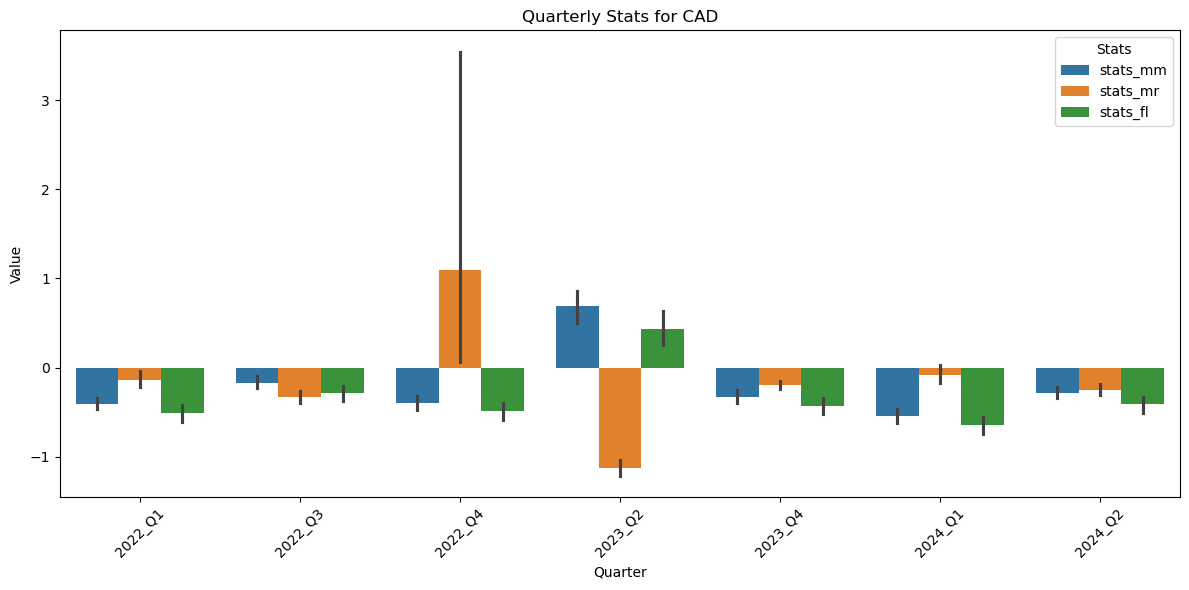

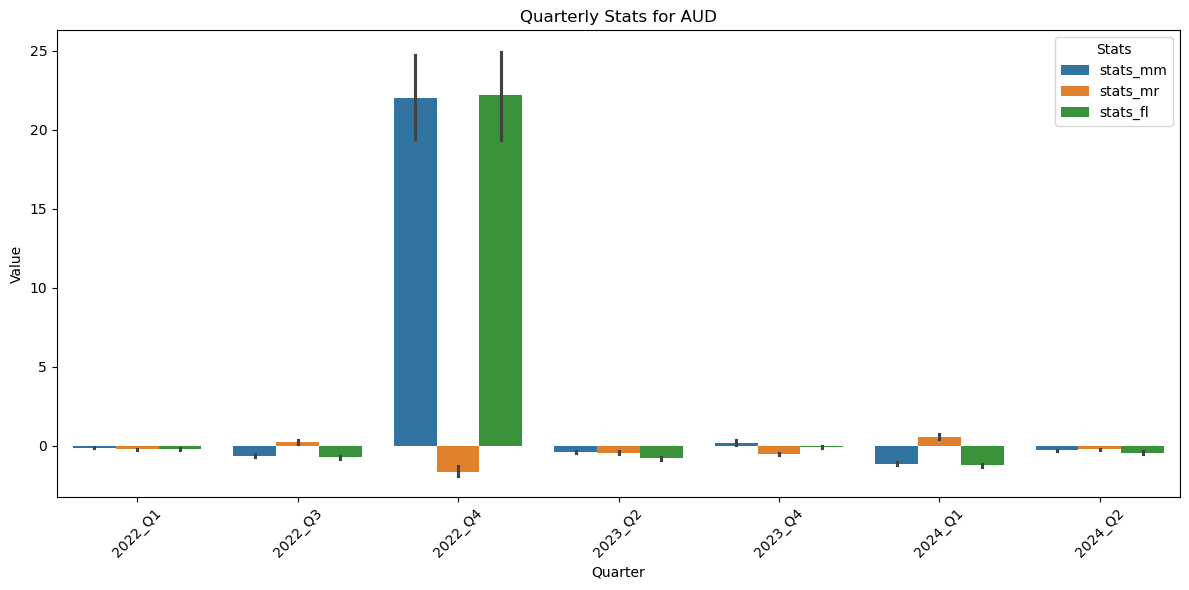

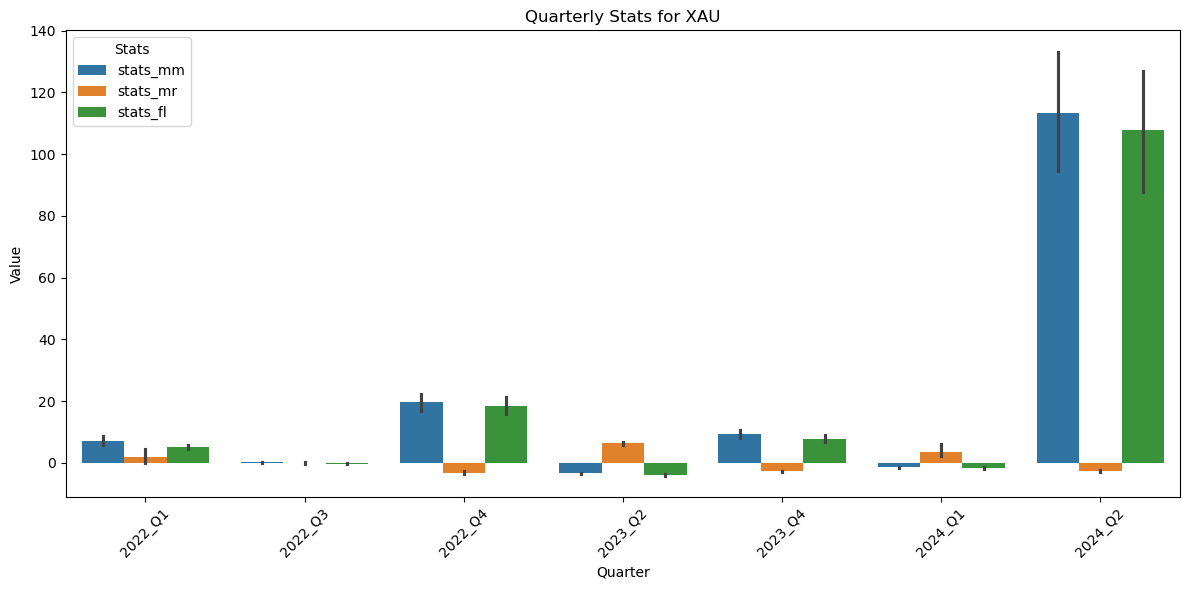

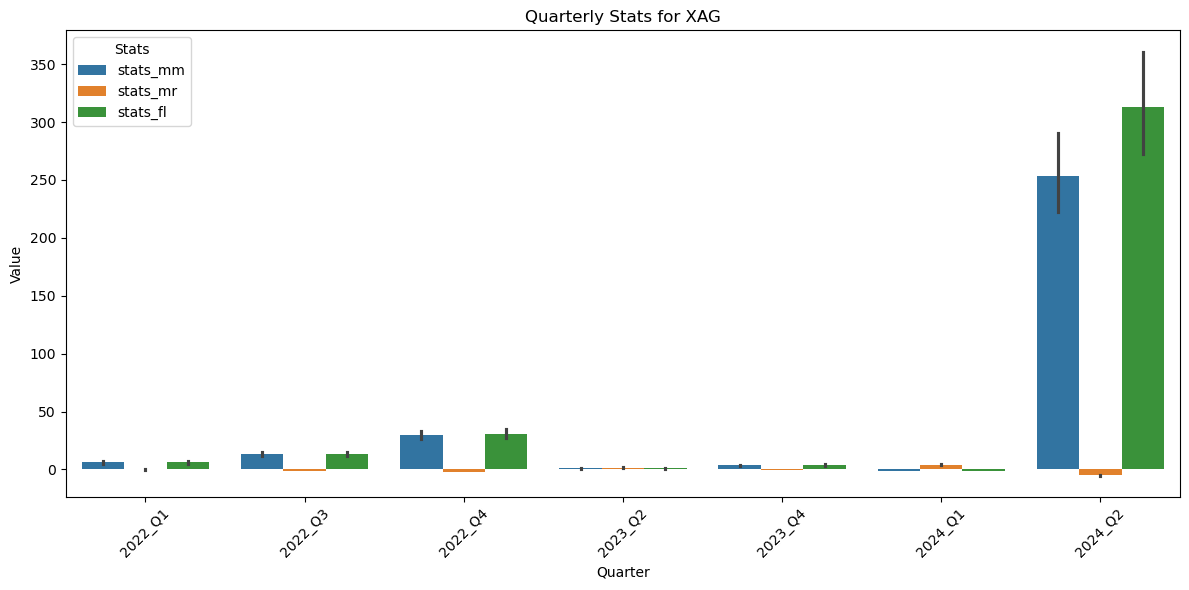

In [500]:
df = vb2_results.query("group_data==2")
for instrument in df['instrument_name'].unique():
    # Filter data for the current instrument
    data = df.query(f"instrument_name == '{instrument}'")

    # Melt the DataFrame to convert stats columns into rows for grouped barplot
    melted_data = data.melt(
        id_vars=["selected_quarter"],
        value_vars=["stats_mm", "stats_mr", "stats_fl"],
        var_name="Stat",
        value_name="Value"
    )

    # Set up the plot
    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=melted_data,
        x="selected_quarter",
        y="Value",
        hue="Stat",
        # ci=None
    )

    # Add plot details
    plt.title(f"Quarterly Stats for {instrument}")
    plt.xlabel("Quarter")
    plt.ylabel("Value")
    plt.legend(title="Stats")
    plt.xticks(rotation=45)

    # Show plot
    plt.tight_layout()
    plt.show()


In [493]:
vb2_gr2.groupby("instrument_name").max()

,stats_mm_mean,stats_mm_std,stats_mr_mean,stats_mr_std,stats_fl_mean,stats_fl_std,stats_mm_mean_corr,stats_mr_mean_corr,stats_fl_mean_corr,max_mean_stats,max_mean_stats_corr
instrument_name,,,,,,,,,,,
AUD,51.222663,135.865433,25.239926,66.995349,52.131313,138.234039,0.152315,0.000000,0.152315,52.131313,0.152315
CAD,4.313473,10.565808,161.978938,428.982225,2.659762,7.037069,0.000000,0.000000,0.000000,161.978938,0.000000
XAG,910.096293,2352.483124,47.743982,98.272108,1425.075120,3711.936241,21.815571,3.669284,72.064090,1425.075120,72.064090
XAU,283.764221,737.439764,176.498080,457.451423,284.379256,737.439764,8.224538,2.429202,7.170482,284.379256,8.224538


In [513]:
df = vb2_gr2.query("instrument_name == 'XAG'").sort_values("max_mean_stats", ascending=False).head(3)
params = {x:y for x,y in df.reset_index().to_dict(orient="records")[0].items() if "stat" not in x}
query_conditions = []
for key, value in params.items():
    if isinstance(value, int):
        query_conditions.append(f"{key} == {value}")
    elif isinstance(value, float):
        query_conditions.append(f"{key} == {round(value, 5)}")
    elif isinstance(value, str):
        query_conditions.append(f"{key} == '{value}'")
query = " and ".join(query_conditions)
vb2_results.query(query)

,selected_quarter,fast_ma,ma_diff,signal_estimator,window_regime,treshold_regime,volat_param,m_exit,m_diff,instrument_name,group_data,p_val,tr_cost,stats_mm,stats_mr,stats_fl
28091,2022_Q1,51,89,mean,98,0.07867,72,1.79056,1.84808,XAG,2,5000,10,0.000000,0.000000,0.000000
28092,2022_Q3,51,89,mean,98,0.07867,72,1.79056,1.84808,XAG,2,5000,10,0.000000,0.000000,0.000000
28093,2022_Q4,51,89,mean,98,0.07867,72,1.79056,1.84808,XAG,2,5000,10,100.046267,-5.548380,100.046267
28094,2023_Q2,51,89,mean,98,0.07867,72,1.79056,1.84808,XAG,2,5000,10,0.000000,-0.591758,0.000000
28095,2023_Q4,51,89,mean,98,0.07867,72,1.79056,1.84808,XAG,2,5000,10,32.568099,-4.135131,32.939080
28096,2024_Q1,51,89,mean,98,0.07867,72,1.79056,1.84808,XAG,2,5000,10,0.000000,0.000000,0.000000
28097,2024_Q2,51,89,mean,98,0.07867,72,1.79056,1.84808,XAG,2,5000,10,2443.684540,-8.176803,9842.540496


In [516]:
vb2_gr2.query("instrument_name == 'XAU'").sort_values("max_mean_stats", ascending=False).head(3)

,,,,,,,,,,,,stats_mm_mean,stats_mm_std,stats_mr_mean,stats_mr_std,stats_fl_mean,stats_fl_std,stats_mm_mean_corr,stats_mr_mean_corr,stats_fl_mean_corr,max_mean_stats,max_mean_stats_corr
fast_ma,ma_diff,signal_estimator,window_regime,treshold_regime,volat_param,m_exit,m_diff,instrument_name,group_data,p_val,tr_cost,,,,,,,,,,,
58,57,median,22,0.57713,73,0.10742,1.91858,XAU,2,100,15,262.726756,584.427930,-1.053431,1.899330,284.379256,638.823242,-29.487209,-2.003096,-35.032365,284.379256,-2.003096
51,48,median,74,0.41845,54,2.46508,0.19409,XAU,2,100,15,283.764221,737.439764,-1.585080,1.982342,283.764221,737.439764,-84.955661,-2.576251,-84.955661,283.764221,-2.576251
57,57,median,23,0.53713,73,0.10957,1.94763,XAU,2,100,15,216.427538,526.627600,-1.034528,1.884952,281.222633,631.001074,-46.886261,-1.977004,-34.277904,281.222633,-1.977004


In [517]:
vb2_gr2.query("instrument_name == 'XAD'").head(10).sort_values("max_mean_stats", ascending=False).head(10)

,,,,,,,,,,,,stats_mm_mean,stats_mm_std,stats_mr_mean,stats_mr_std,stats_fl_mean,stats_fl_std,stats_mm_mean_corr,stats_mr_mean_corr,stats_fl_mean_corr,max_mean_stats,max_mean_stats_corr
fast_ma,ma_diff,signal_estimator,window_regime,treshold_regime,volat_param,m_exit,m_diff,instrument_name,group_data,p_val,tr_cost,,,,,,,,,,,


# VB

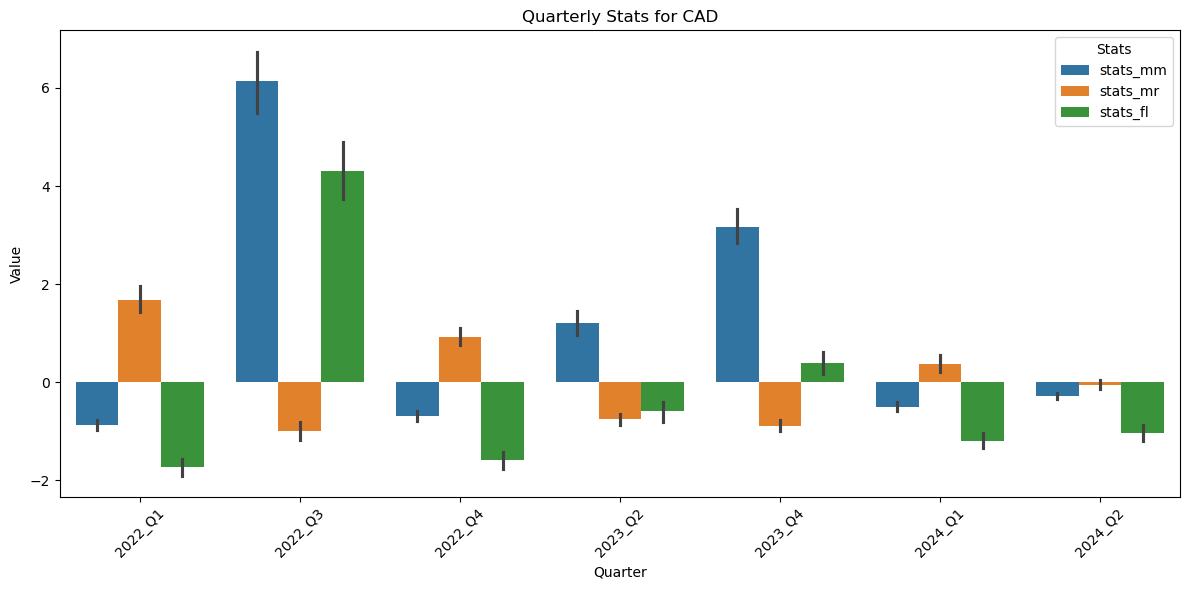

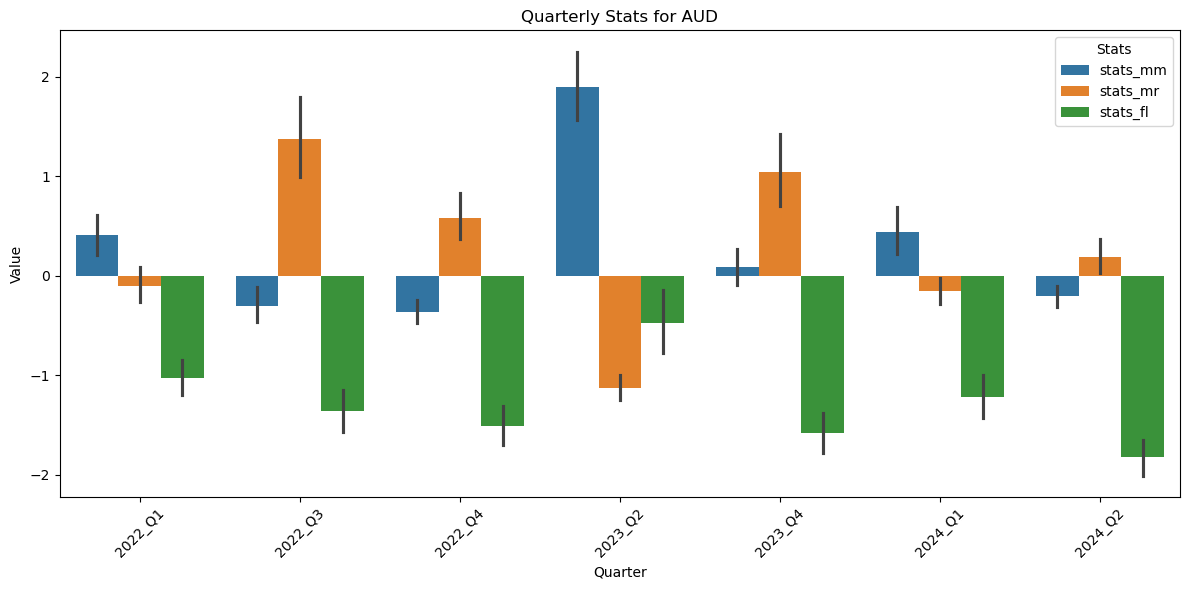

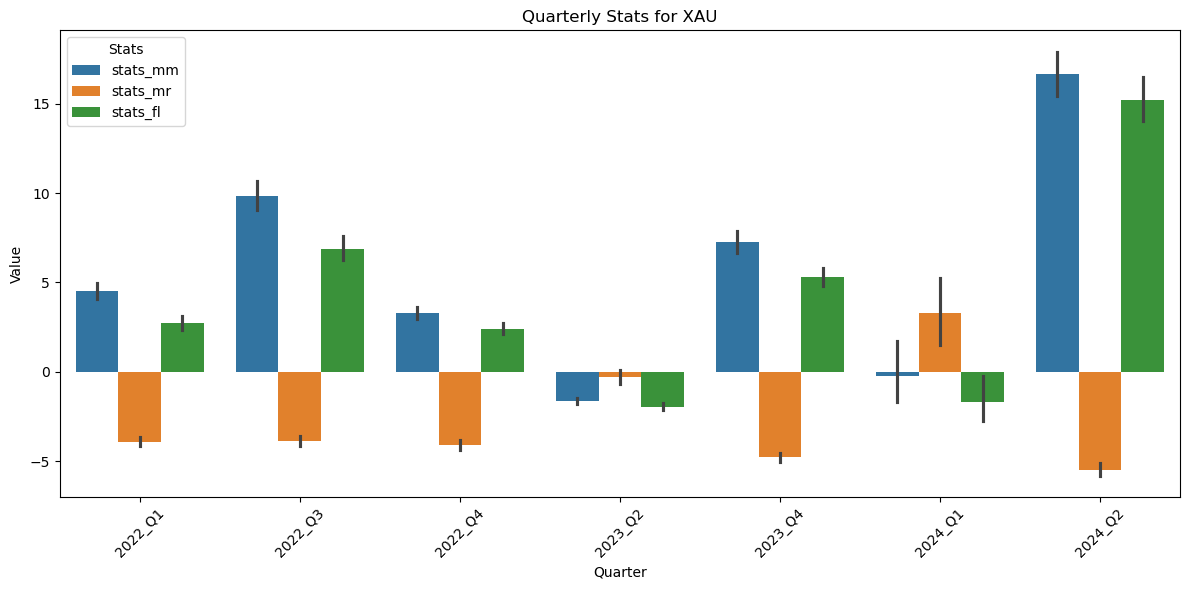

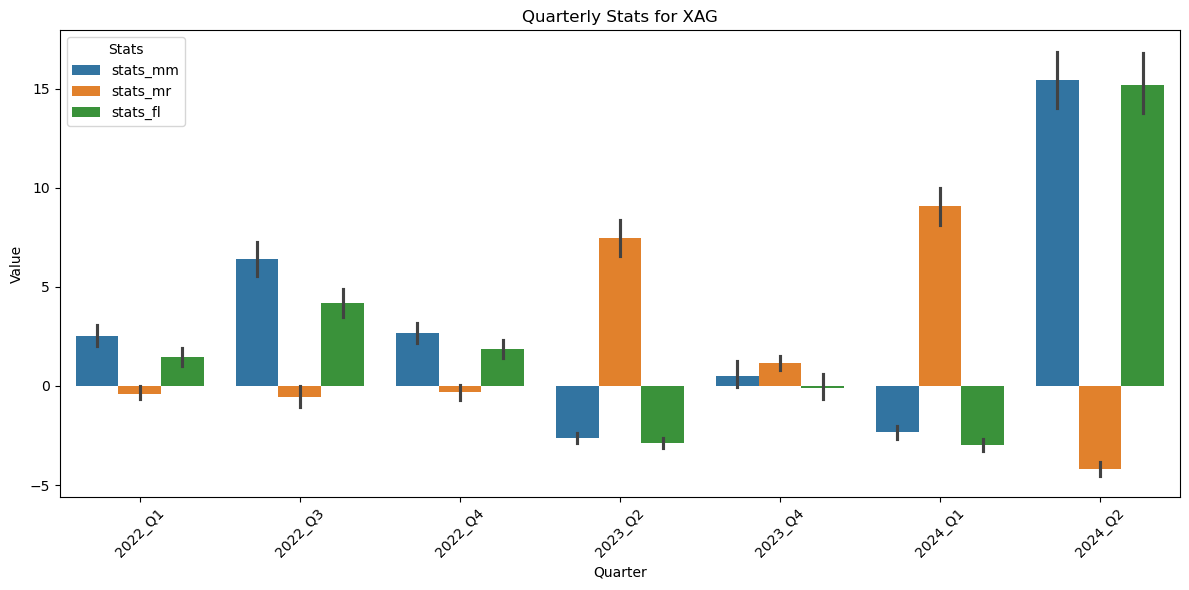

In [502]:
df = vb_results.query("group_data==2")
for instrument in df['instrument_name'].unique():
    # Filter data for the current instrument
    data = df.query(f"instrument_name == '{instrument}'")

    # Melt the DataFrame to convert stats columns into rows for grouped barplot
    melted_data = data.melt(
        id_vars=["selected_quarter"],
        value_vars=["stats_mm", "stats_mr", "stats_fl"],
        var_name="Stat",
        value_name="Value"
    )

    # Set up the plot
    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=melted_data,
        x="selected_quarter",
        y="Value",
        hue="Stat",
        # ci=None
    )

    # Add plot details
    plt.title(f"Quarterly Stats for {instrument}")
    plt.xlabel("Quarter")
    plt.ylabel("Value")
    plt.legend(title="Stats")
    plt.xticks(rotation=45)

    # Show plot
    plt.tight_layout()
    plt.show()


## GR1

In [441]:
vb_gr1.query("instrument_name == 'SP'").sort_values("max_mean_stats_corr", ascending=False).head(3)

stats_mm_mean  \
fast_ma ma_diff signal_estimator window_regime treshold_regime volat_param m_      instrument_name group_data p_val tr_cost                  
18      60      median           43            0.10757         100         1.79767 SP              1          50    12           35.666826   
        59      median           44            0.07247         98          1.79910 SP              1          50    12           32.897057   
                                               0.07658         98          1.79904 SP              1          50    12           32.897057   

                                                                                                                             stats_mm_std  \
fast_ma ma_diff signal_estimator window_regime treshold_regime volat_param m_      instrument_name group_data p_val tr_cost                 
18      60      median           43            0.10757         100         1.79767 SP              1          50    12          45.416757   
        59      median           44            0.07247         98          1.79910 SP              1          50    12          39.978592   
                                               0.07658         98          1.79904 SP              1          50    12          39.978592   

                                                                                                                             stats_mr_mean  \
fast_ma ma_diff signal_estimator window_regime treshold_regime volat_param m_      instrument_name group_data p_val tr_cost                  
18      60      median           43            0.10757         100         1.79767 SP              1          50    12           -7.933947   
        59      median           44            0.07247         98          1.79910 SP              1          50    12           -7.986723   
                                               0.07658         98          1.79904 SP              1          50    12           -7.986723   

                                                                                                                             stats_mr_std  \
fast_ma ma_diff signal_estimator window_regime treshold_regime volat_param m_      instrument_name group_data p_val tr_cost                 
18      60      median           43            0.10757         100         1.79767 SP              1          50    12           4.222933   
        59      median           44            0.07247         98          1.79910 SP              1          50    12           3.930727   
                                               0.07658         98          1.79904 SP              1          50    12           3.930727   

                                                                                                                             stats_fl_mean  \
fast_ma ma_diff signal_estimator window_regime treshold_regime volat_param m_      instrument_name group_data p_val tr_cost                  
18      60      median           43            0.10757         100         1.79767 SP              1          50    12           34.810137   
        59      median           44            0.07247         98          1.79910 SP              1          50    12           31.908134   
                                               0.07658         98          1.79904 SP              1          50    12           31.908134   

                                                                                                                             stats_fl_std  \
fast_ma ma_diff signal_estimator window_regime treshold_regime volat_param m_      instrument_name group_data p_val tr_cost                 
18      60      median           43            0.10757         100         1.79767 SP              1          50    12          45.131475   
        59      median           44            0.07247         98          1.79910 SP              1          50    12          39.665549   
                

In [345]:
df = vb2_gr1.query("instrument_name == 'SP'").sort_values("max_sum_stats", ascending=False).head(3)
params = {x:y for x,y in df.reset_index().to_dict(orient="records")[0].items() if "stat" not in x}
query_conditions = []
for key, value in params.items():
    if isinstance(value, int):
        query_conditions.append(f"{key} == {value}")
    elif isinstance(value, float):
        query_conditions.append(f"{key} == {round(value, 5)}")
    elif isinstance(value, str):
        query_conditions.append(f"{key} == '{value}'")
query = " and ".join(query_conditions)
vb2_results.query(query)

,selected_quarter,fast_ma,ma_diff,signal_estimator,window_regime,treshold_regime,volat_param,m_exit,m_diff,instrument_name,group_data,p_val,tr_cost,stats_mm,stats_mr,stats_fl
9989,2022_Q1,72,62,median,48,0.16716,61,2.70505,1.36318,SP,1,50,12,3546.016742,-9.085911,6166.964411
9990,2022_Q3,72,62,median,48,0.16716,61,2.70505,1.36318,SP,1,50,12,0.538328,-1.182787,0.538328
9991,2022_Q4,72,62,median,48,0.16716,61,2.70505,1.36318,SP,1,50,12,2.408703,-3.421650,2.408703
9992,2023_Q2,72,62,median,48,0.16716,61,2.70505,1.36318,SP,1,50,12,0.000000,-1.870886,-2.607497
9993,2023_Q4,72,62,median,48,0.16716,61,2.70505,1.36318,SP,1,50,12,0.000000,0.000000,0.000000
9994,2024_Q1,72,62,median,48,0.16716,61,2.70505,1.36318,SP,1,50,12,-4.124578,10.130604,-4.193181
9995,2024_Q2,72,62,median,48,0.16716,61,2.70505,1.36318,SP,1,50,12,16.545859,-4.843227,15.982410


In [443]:
vb_gr1.query("instrument_name == 'SP'").sort_values("max_mean_stats", ascending=False).head(5)

,,,,,,,,,,,stats_mm_mean,stats_mm_std,stats_mr_mean,stats_mr_std,stats_fl_mean,stats_fl_std,stats_mm_mean_corr,stats_mr_mean_corr,stats_fl_mean_corr,max_mean_stats,max_mean_stats_corr
fast_ma,ma_diff,signal_estimator,window_regime,treshold_regime,volat_param,m_,instrument_name,group_data,p_val,tr_cost,,,,,,,,,,,
39,44,mean,68,0.65503,68,1.41443,SP,1,50,12,190.617118,483.593785,-3.680389,3.306332,125.968318,317.773326,-51.179774,-5.333555,-32.918345,190.617118,-5.333555
34,47,mean,2,0.40948,51,2.72371,SP,1,50,12,145.665093,342.493810,-3.891500,3.226409,-11.466118,3.521749,-25.581812,-5.504705,-13.226992,145.665093,-5.504705
20,44,mean,70,0.19575,52,1.86294,SP,1,50,12,71.998134,192.563497,0.197934,4.956831,21.864451,62.417613,-24.283615,-2.280481,-9.344356,71.998134,-2.280481
19,56,median,38,0.11787,90,1.59321,SP,1,50,12,39.977757,60.937771,-6.470116,6.463354,38.424373,61.531379,9.508871,-9.701793,7.658684,39.977757,9.508871
36,48,median,83,0.35482,15,2.65307,SP,1,50,12,39.586919,60.201942,-8.760703,4.563078,38.397015,60.572255,9.485948,-11.042241,8.110887,39.586919,9.485948


In [444]:
df = vb_gr1.query("instrument_name == 'NQ'").sort_values("max_mean_stats_corr", ascending=False).head(2)
params = {x:y for x,y in df.reset_index().to_dict(orient="records")[0].items() if "stat" not in x}
query_conditions = []
for key, value in params.items():
    if isinstance(value, int):
        query_conditions.append(f"{key} == {value}")
    elif isinstance(value, float):
        query_conditions.append(f"{key} == {round(value, 5)}")
    elif isinstance(value, str):
        query_conditions.append(f"{key} == '{value}'")
query = " and ".join(query_conditions)
vb_results.query(query)

,selected_quarter,fast_ma,ma_diff,signal_estimator,window_regime,treshold_regime,volat_param,m_,instrument_name,group_data,p_val,tr_cost,stats_mm,stats_mr,stats_fl
25809,2022_Q1,57,57,mean,40,0.64827,68,2.66573,NQ,1,20,12,12.146137,-6.200384,16.036433
25810,2022_Q3,57,57,mean,40,0.64827,68,2.66573,NQ,1,20,12,1592.376765,-10.735678,1726.639276
25811,2022_Q4,57,57,mean,40,0.64827,68,2.66573,NQ,1,20,12,516.302305,-12.029715,1449.253524
25812,2023_Q2,57,57,mean,40,0.64827,68,2.66573,NQ,1,20,12,7.562182,-6.299995,0.000000
25813,2023_Q4,57,57,mean,40,0.64827,68,2.66573,NQ,1,20,12,0.000000,-0.577634,-6.198740
25814,2024_Q1,57,57,mean,40,0.64827,68,2.66573,NQ,1,20,12,0.000000,0.000000,-0.761345
25815,2024_Q2,57,57,mean,40,0.64827,68,2.66573,NQ,1,20,12,-0.849189,0.224987,-3.348018


In [439]:
vb_gr1.query("instrument_name == 'NQ'").sort_values("max_mean_stats_corr", ascending=False).head(2)

,,,,,,,,,,,stats_mm_mean,stats_mm_std,stats_mr_mean,stats_mr_std,stats_fl_mean,stats_fl_std,stats_mm_mean_corr,stats_mr_mean_corr,stats_fl_mean_corr,max_mean_stats,max_mean_stats_corr
fast_ma,ma_diff,signal_estimator,window_regime,treshold_regime,volat_param,m_,instrument_name,group_data,p_val,tr_cost,,,,,,,,,,,
57,57,mean,40,0.64827,68,2.66573,NQ,1,20,12,303.934028,599.417219,-5.088346,5.119391,454.517304,778.441230,4.225419,-7.648041,65.296689,454.517304,65.296689
53,56,mean,42,0.62494,67,2.57739,NQ,1,20,12,264.858544,507.034066,-4.856440,4.916291,390.528556,657.905032,11.341511,-7.314585,61.576040,390.528556,61.576040


In [510]:
vb_gr1.query("instrument_name == 'NQ'").sort_values("max_mean_stats", ascending=False).head(3)

stats_mm_mean  \
fast_ma ma_diff signal_estimator window_regime treshold_regime volat_param m_      instrument_name group_data p_val tr_cost                  
57      58      mean             41            0.66677         69          2.68167 NQ              1          20    12          517.454750   
        59      mean             41            0.50270         70          2.62781 NQ              1          20    12          545.941031   
54      58      mean             42            0.67346         68          2.63429 NQ              1          20    12          353.018129   

                                                                                                                             stats_mm_std  \
fast_ma ma_diff signal_estimator window_regime treshold_regime volat_param m_      instrument_name group_data p_val tr_cost                 
57      58      mean             41            0.66677         69          2.68167 NQ              1          20    12        1262.877839   
        59      mean             41            0.50270         70          2.62781 NQ              1          20    12        1317.241286   
54      58      mean             42            0.67346         68          2.63429 NQ              1          20    12         734.602856   

                                                                                                                             stats_mr_mean  \
fast_ma ma_diff signal_estimator window_regime treshold_regime volat_param m_      instrument_name group_data p_val tr_cost                  
57      58      mean             41            0.66677         69          2.68167 NQ              1          20    12           -5.153582   
        59      mean             41            0.50270         70          2.62781 NQ              1          20    12           -4.800940   
54      58      mean             42            0.67346         68          2.63429 NQ              1          20    12           -5.513879   

                                                                                                                             stats_mr_std  \
fast_ma ma_diff signal_estimator window_regime treshold_regime volat_param m_      instrument_name group_data p_val tr_cost                 
57      58      mean             41            0.66677         69          2.68167 NQ              1          20    12           4.973494   
        59      mean             41            0.50270         70          2.62781 NQ              1          20    12           5.340510   
54      58      mean             42            0.67346         68          2.63429 NQ              1          20    12           4.745652   

                                                                                                                             stats_fl_mean  \
fast_ma ma_diff signal_estimator window_regime treshold_regime volat_param m_      instrument_name group_data p_val tr_cost                  
57      58      mean             41            0.66677         69          2.68167 NQ              1          20    12          621.573528   
        59      mean             41            0.50270         70          2.62781 NQ              1          20    12          591.937754   
54      58      mean             42            0.67346         68          2.63429 NQ              1          20    12          484.009151   

                                                                                                                             stats_fl_std  \
fast_ma ma_diff signal_estimator window_regime treshold_regime volat_param m_      instrument_name group_data p_val tr_cost                 
57      58      mean             41            0.66677         69          2.68167 NQ              1          20    12        1530.269012   
        59      mean             41            0.50270         70          2.62781 NQ              1          20    12        1420.364016   
54      58      

## GR2

In [375]:
vb_gr2

stats_mm_sum  \
fast_ma ma_diff signal_estimator window_regime treshold_regime volat_param m_      instrument_name group_data p_val  tr_cost                 
29      7       median           76            0.17171         28          1.46339 XAG             2          5000   10         -39.292773   
31      57      median           96            0.03678         13          0.41912 XAU             2          100    15         141.337227   
                                 98            0.01932         13          0.41566 XAU             2          100    15         141.556677   
33      55      median           94            0.04843         11          0.47290 XAU             2          100    15         167.972290   
31      57      median           96            0.42679         9           0.53374 XAU             2          100    15         155.701073   
...                                                                                                                                    ...   
1       60      mean             19            0.53968         57          0.42901 CAD             2          100000 10         -48.260908   
7       23      mean             32            0.46923         2           2.78928 CAD             2          100000 10         -53.264491   
1       26      mean             79            0.54473         3           2.54723 AUD             2          100000 10         -51.544701   
9       4       mean             69            0.00233         4           0.93453 CAD             2          100000 10         -60.663709   
1       1       mean             36            0.37124         40          0.15566 CAD             2          100000 10         -96.509485   

                                                                                                                              stats_mm_std  \
fast_ma ma_diff signal_estimator window_regime treshold_regime volat_param m_      instrument_name group_data p_val  tr_cost                 
29      7       median           76            0.17171         28          1.46339 XAG             2          5000   10           3.815484   
31      57      median           96            0.03678         13          0.41912 XAU             2          100    15          22.862019   
                                 98            0.01932         13          0.41566 XAU             2          100    15          23.041489   
33      55      median           94            0.04843         11          0.47290 XAU             2          100    15          31.849951   
31      57      median           96            0.42679         9           0.53374 XAU             2          100    15          27.774240   
...                                                                                                                                    ...   
1       60      mean             19            0.53968         57          0.42901 CAD             2          100000 10           1.057761   
7       23      mean             32            0.46923         2           2.78928 CAD             2          100000 10           0.498037   
1       26      mean             79            0.54473         3           2.54723 AUD             2          100000 10           0.607368   
9       4       mean             69            0.00233         4           0.93453 CAD             2          100000 10           0.804748   
1       1       mean             36            0.37124         40          0.15566 CAD             2          100000 10           0.395616   

                                                                                                                              stats_mr_sum  \
fast_ma ma_diff signal_estimator window_regime treshold_regime volat_param m_      instrument_name group_data p_val  tr_cost                 
29      7       median           76            0.17171         28          1.46339 XAG             2          5000   10         206.801144   
31    

In [367]:
vb_gr2.query("instrument_name == 'XAG'").head(5)

stats_mm_sum  \
fast_ma ma_diff signal_estimator window_regime treshold_regime volat_param m_      instrument_name group_data p_val tr_cost                 
29      7       median           76            0.17171         28          1.46339 XAG             2          5000  10         -39.292773   
59      8       median           77            0.18152         28          1.29500 XAG             2          5000  10         202.112547   
                                 78            0.36401         28          1.26730 XAG             2          5000  10         174.062422   
58      8       median           76            0.40695         25          1.41026 XAG             2          5000  10         165.568136   
62      8       median           75            0.21740         29          1.28927 XAG             2          5000  10         118.905164   

                                                                                                                             stats_mm_std  \
fast_ma ma_diff signal_estimator window_regime treshold_regime volat_param m_      instrument_name group_data p_val tr_cost                 
29      7       median           76            0.17171         28          1.46339 XAG             2          5000  10           3.815484   
59      8       median           77            0.18152         28          1.29500 XAG             2          5000  10          45.875541   
                                 78            0.36401         28          1.26730 XAG             2          5000  10          39.058347   
58      8       median           76            0.40695         25          1.41026 XAG             2          5000  10          36.424367   
62      8       median           75            0.21740         29          1.28927 XAG             2          5000  10          21.933529   

                                                                                                                             stats_mr_sum  \
fast_ma ma_diff signal_estimator window_regime treshold_regime volat_param m_      instrument_name group_data p_val tr_cost                 
29      7       median           76            0.17171         28          1.46339 XAG             2          5000  10         206.801144   
59      8       median           77            0.18152         28          1.29500 XAG             2          5000  10         -14.459125   
                                 78            0.36401         28          1.26730 XAG             2          5000  10         -13.480239   
58      8       median           76            0.40695         25          1.41026 XAG             2          5000  10         -33.947474   
62      8       median           75            0.21740         29          1.28927 XAG             2          5000  10         -20.034132   

                                                                                                                             stats_mr_std  \
fast_ma ma_diff signal_estimator window_regime treshold_regime volat_param m_      instrument_name group_data p_val tr_cost                 
29      7       median           76            0.17171         28          1.46339 XAG             2          5000  10          36.658822   
59      8       median           77            0.18152         28          1.29500 XAG             2          5000  10          10.098961   
                                 78            0.36401         28          1.26730 XAG             2          5000  10          10.047042   
58      8       median           76            0.40695         25          1.41026 XAG             2          5000  10           5.789406   
62      8       median           75            0.21740         29          1.28927 XAG             2          5000  10           9.197337   

                                                                                                                             stats_fl_sum  \
fast_ma ma_diff signal_estimator

In [368]:
vb_gr2.query("instrument_name == 'XAU'").head(5)

stats_mm_sum  \
fast_ma ma_diff signal_estimator window_regime treshold_regime volat_param m_      instrument_name group_data p_val tr_cost                 
31      57      median           96            0.03678         13          0.41912 XAU             2          100   15         141.337227   
                                 98            0.01932         13          0.41566 XAU             2          100   15         141.556677   
33      55      median           94            0.04843         11          0.47290 XAU             2          100   15         167.972290   
31      57      median           96            0.42679         9           0.53374 XAU             2          100   15         155.701073   
        56      median           96            0.04157         11          0.39932 XAU             2          100   15         158.772483   

                                                                                                                             stats_mm_std  \
fast_ma ma_diff signal_estimator window_regime treshold_regime volat_param m_      instrument_name group_data p_val tr_cost                 
31      57      median           96            0.03678         13          0.41912 XAU             2          100   15          22.862019   
                                 98            0.01932         13          0.41566 XAU             2          100   15          23.041489   
33      55      median           94            0.04843         11          0.47290 XAU             2          100   15          31.849951   
31      57      median           96            0.42679         9           0.53374 XAU             2          100   15          27.774240   
        56      median           96            0.04157         11          0.39932 XAU             2          100   15          28.901782   

                                                                                                                             stats_mr_sum  \
fast_ma ma_diff signal_estimator window_regime treshold_regime volat_param m_      instrument_name group_data p_val tr_cost                 
31      57      median           96            0.03678         13          0.41912 XAU             2          100   15         -54.543147   
                                 98            0.01932         13          0.41566 XAU             2          100   15         -51.326678   
33      55      median           94            0.04843         11          0.47290 XAU             2          100   15         -56.592853   
31      57      median           96            0.42679         9           0.53374 XAU             2          100   15         -56.453262   
        56      median           96            0.04157         11          0.39932 XAU             2          100   15         -53.479338   

                                                                                                                             stats_mr_std  \
fast_ma ma_diff signal_estimator window_regime treshold_regime volat_param m_      instrument_name group_data p_val tr_cost                 
31      57      median           96            0.03678         13          0.41912 XAU             2          100   15           4.664527   
                                 98            0.01932         13          0.41566 XAU             2          100   15           5.840918   
33      55      median           94            0.04843         11          0.47290 XAU             2          100   15           4.134983   
31      57      median           96            0.42679         9           0.53374 XAU             2          100   15           4.232992   
        56      median           96            0.04157         11          0.39932 XAU             2          100   15           5.000794   

                                                                                                                             stats_fl_sum  \
fast_ma ma_diff signal_estimator

# MA

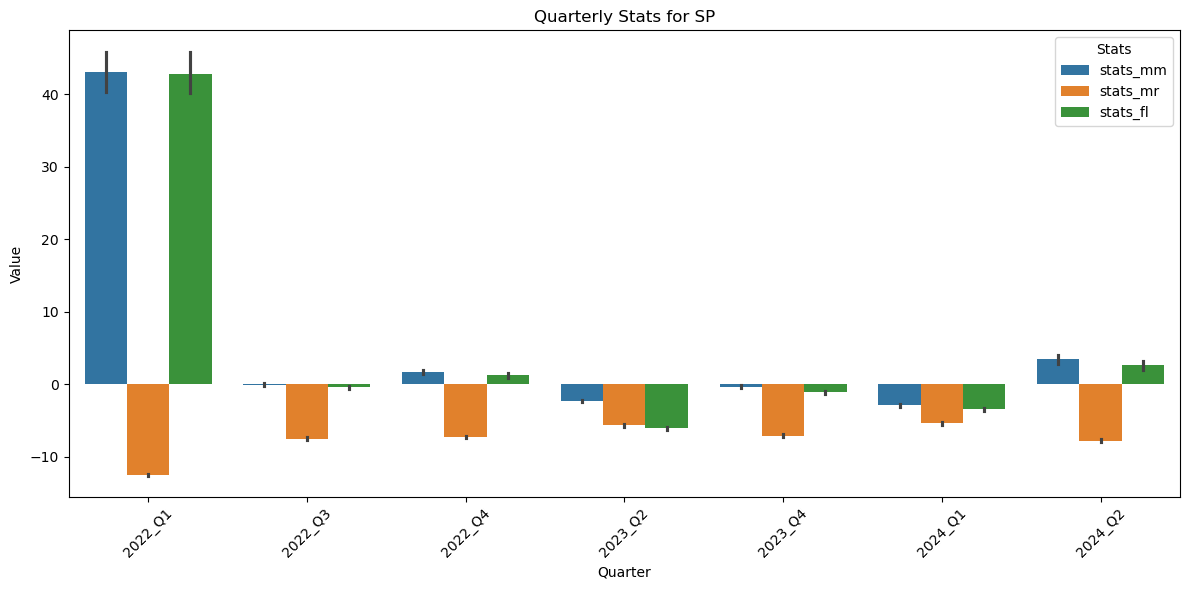

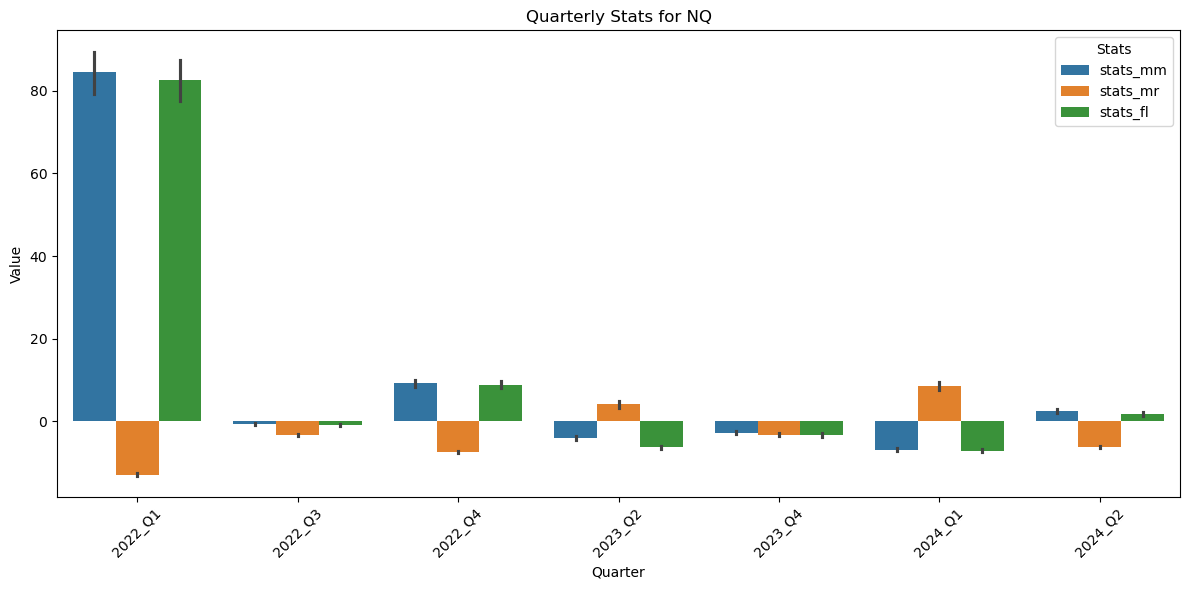

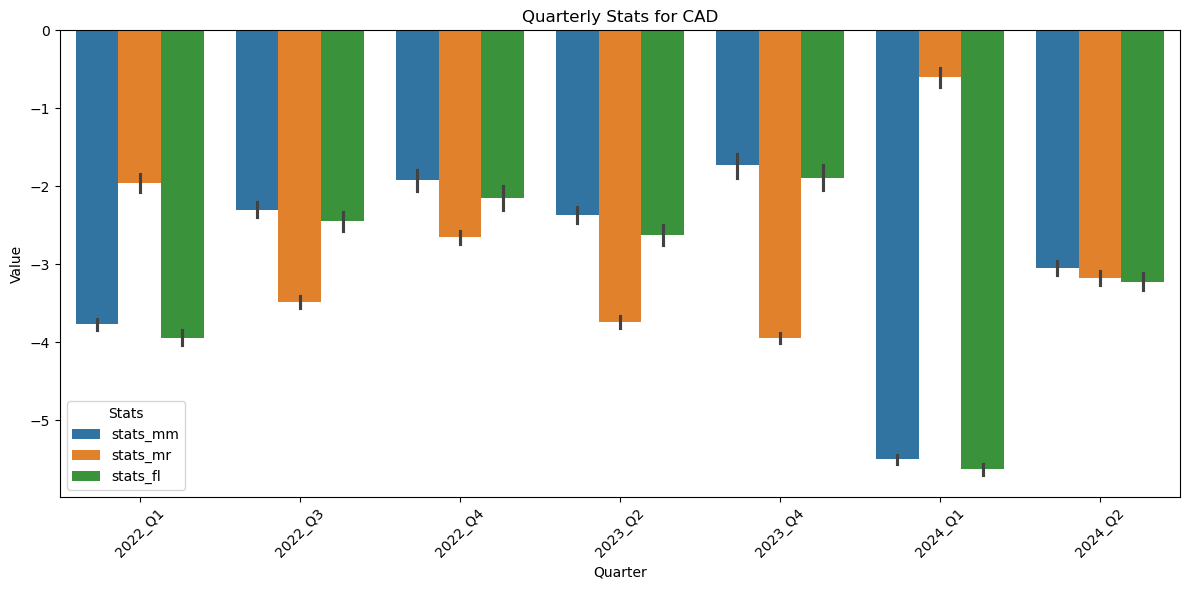

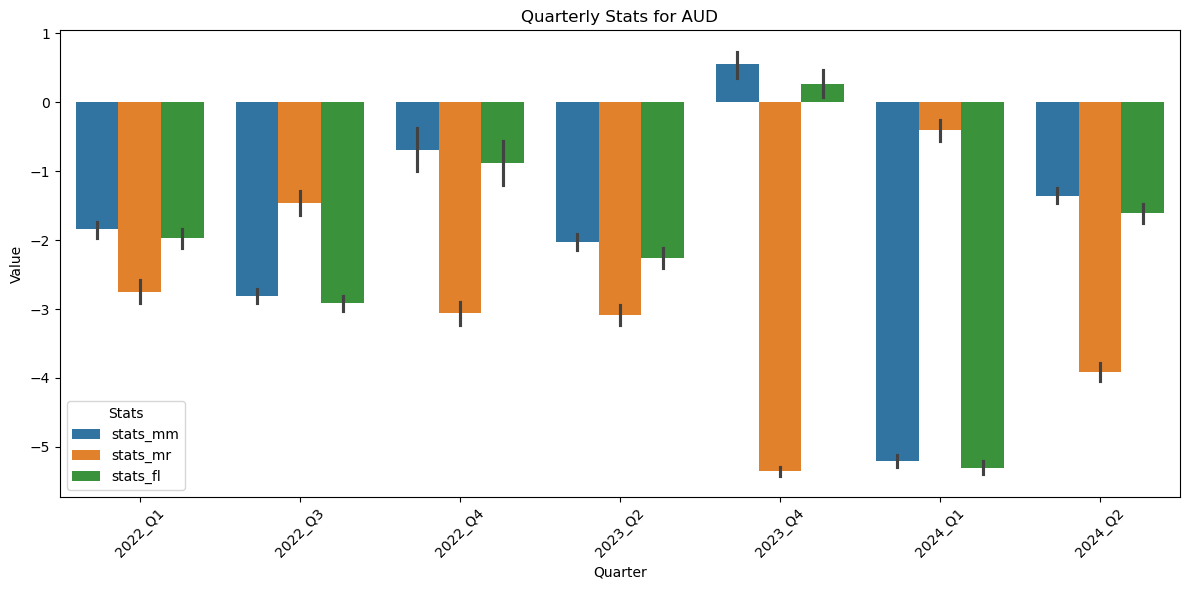

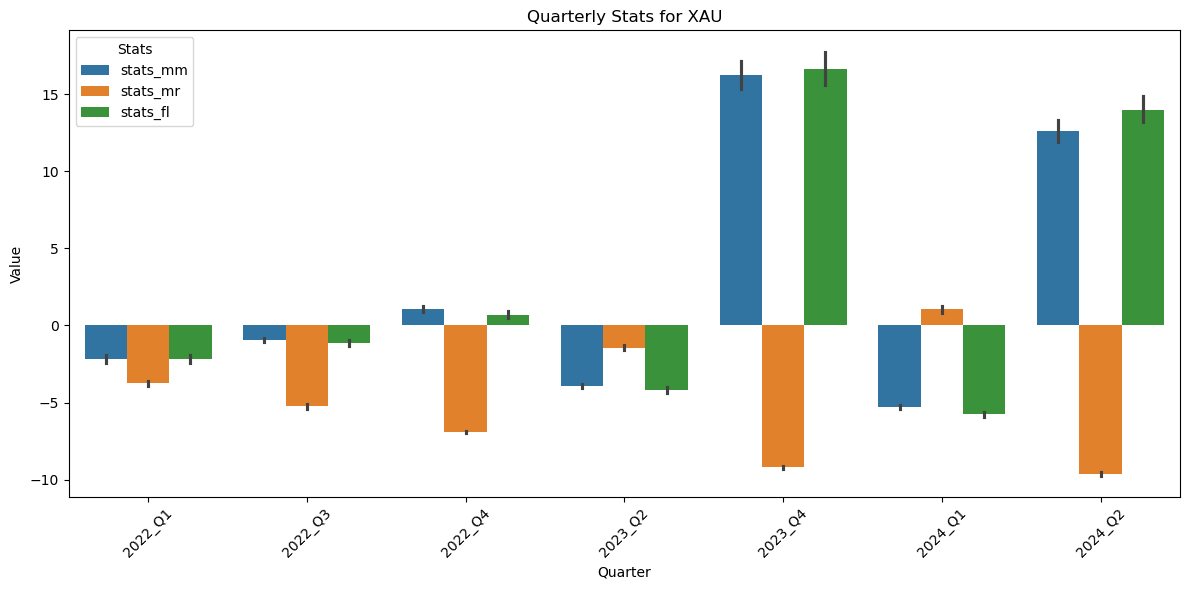

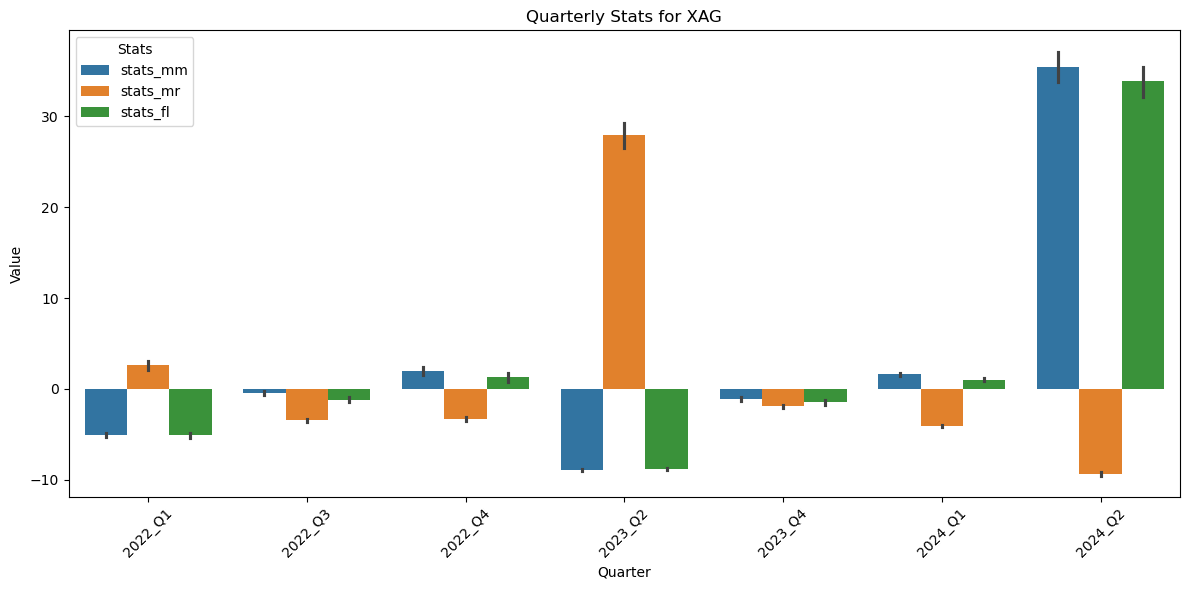

In [369]:
df = ma_results
for instrument in df['instrument_name'].unique():
    # Filter data for the current instrument
    data = df.query(f"instrument_name == '{instrument}'")

    # Melt the DataFrame to convert stats columns into rows for grouped barplot
    melted_data = data.melt(
        id_vars=["selected_quarter"],
        value_vars=["stats_mm", "stats_mr", "stats_fl"],
        var_name="Stat",
        value_name="Value"
    )

    # Set up the plot
    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=melted_data,
        x="selected_quarter",
        y="Value",
        hue="Stat",
        # ci=None
    )

    # Add plot details
    plt.title(f"Quarterly Stats for {instrument}")
    plt.xlabel("Quarter")
    plt.ylabel("Value")
    plt.legend(title="Stats")
    plt.xticks(rotation=45)

    # Show plot
    plt.tight_layout()
    plt.show()


## GR1

In [370]:
ma_gr1.query("instrument_name == 'SP'").head(5)

stats_mm_sum  \
fast_ma ma_diff signal_estimator window_regime treshold_regime instrument_name group_data p_val tr_cost                 
38      25      median           76            0.30673         SP              1          50    12          42.412702   
                                 77            0.27054         SP              1          50    12          42.412702   
                                               0.27517         SP              1          50    12          42.412702   
                                               0.29854         SP              1          50    12          42.412702   
                                               0.31070         SP              1          50    12          42.412702   

                                                                                                         stats_mm_std  \
fast_ma ma_diff signal_estimator window_regime treshold_regime instrument_name group_data p_val tr_cost                 
38      25      median           76            0.30673         SP              1          50    12           8.910585   
                                 77            0.27054         SP              1          50    12           8.910585   
                                               0.27517         SP              1          50    12           8.910585   
                                               0.29854         SP              1          50    12           8.910585   
                                               0.31070         SP              1          50    12           8.910585   

                                                                                                         stats_mr_sum  \
fast_ma ma_diff signal_estimator window_regime treshold_regime instrument_name group_data p_val tr_cost                 
38      25      median           76            0.30673         SP              1          50    12          -74.93162   
                                 77            0.27054         SP              1          50    12          -74.93162   
                                               0.27517         SP              1          50    12          -74.93162   
                                               0.29854         SP              1          50    12          -74.93162   
                                               0.31070         SP              1          50    12          -74.93162   

                                                                                                         stats_mr_std  \
fast_ma ma_diff signal_estimator window_regime treshold_regime instrument_name group_data p_val tr_cost                 
38      25      median           76            0.30673         SP              1          50    12           1.650516   
                                 77            0.27054         SP              1          50    12           1.650516   
                                               0.27517         SP              1          50    12           1.650516   
                                               0.29854         SP              1          50    12           1.650516   
                                               0.31070         SP              1          50    12           1.650516   

                                                                                                         stats_fl_sum  \
fast_ma ma_diff signal_estimator window_regime treshold_regime instrument_name group_data p_val tr_cost                 
38      25      median           76            0.30673         SP              1          50    12          36.249433   
                                 77            0.27054         SP              1          50    12          37.368054   
                                               0.27517         SP              1          50    12          37.123213   
                                               0.29854         SP              1          50    12          

In [371]:
ma_gr1.query("instrument_name == 'NQ'").head(5)

,,,,,,,,,stats_mm_sum,stats_mm_std,stats_mr_sum,stats_mr_std,stats_fl_sum,stats_fl_std,stats_mm_sum_corr,stats_mr_sum_corr,stats_fl_sum_corr,max_sum_stats,max_sum_stats_corr
fast_ma,ma_diff,signal_estimator,window_regime,treshold_regime,instrument_name,group_data,p_val,tr_cost,,,,,,,,,,,
100,11,mean,63,0.40533,NQ,1,20,12,75.318315,19.273463,-53.817651,5.316926,51.753955,17.573484,17.497926,-69.768430,-0.966497,75.318315,17.497926
83,78,mean,39,0.40067,NQ,1,20,12,113.184913,32.482507,-12.878177,11.902827,99.886904,33.686897,15.737393,-48.586659,-1.173787,113.184913,15.737393
40,44,mean,63,0.28624,NQ,1,20,12,28.717527,5.667311,-54.337389,2.802425,15.647039,8.103522,11.715593,-62.744665,-8.663529,28.717527,11.715593
20,47,mean,28,0.19504,NQ,1,20,12,67.902579,19.196475,-61.309333,5.913855,49.368872,16.873660,10.313154,-79.050897,-1.252107,67.902579,10.313154
40,42,mean,69,0.05280,NQ,1,20,12,23.409845,4.462005,-56.517410,2.302934,20.692875,4.571992,10.023830,-63.426213,6.976900,23.409845,10.023830


## GR2

In [372]:
ma_gr2.groupby("instrument_name").max()

,stats_mm_sum,stats_mm_std,stats_mr_sum,stats_mr_std,stats_fl_sum,stats_fl_std,stats_mm_sum_corr,stats_mr_sum_corr,stats_fl_sum_corr,max_sum_stats,max_sum_stats_corr
instrument_name,,,,,,,,,,,
AUD,6.276856,8.212254,-3.079029,8.318272,6.590039,8.328840,-9.426331,-14.412820,-9.707854,6.590039,-9.426331
CAD,-11.550902,2.327846,-2.289773,2.464205,-11.442626,2.380426,-16.930400,-3.932614,-16.839022,-2.289773,-3.932614
XAG,87.507750,39.964567,66.978377,36.203351,85.875152,41.199370,2.123770,-0.645609,2.144676,87.507750,2.144676
XAU,61.057628,23.933957,-2.692037,7.496773,72.467240,24.411313,9.271530,-18.862485,8.207196,72.467240,9.271530


In [373]:
ma_gr2.query("instrument_name == 'XAG'").head(5)

stats_mm_sum  \
fast_ma ma_diff signal_estimator window_regime treshold_regime instrument_name group_data p_val tr_cost                 
29      60      mean             80            0.21409         XAG             2          5000  10          27.957274   
                                 81            0.21988         XAG             2          5000  10          27.957274   
                                 75            0.21181         XAG             2          5000  10          27.957274   
                                               0.21678         XAG             2          5000  10          27.957274   
                                 99            0.19190         XAG             2          5000  10          27.957274   

                                                                                                         stats_mm_std  \
fast_ma ma_diff signal_estimator window_regime treshold_regime instrument_name group_data p_val tr_cost                 
29      60      mean             80            0.21409         XAG             2          5000  10           8.611168   
                                 81            0.21988         XAG             2          5000  10           8.611168   
                                 75            0.21181         XAG             2          5000  10           8.611168   
                                               0.21678         XAG             2          5000  10           8.611168   
                                 99            0.19190         XAG             2          5000  10           8.611168   

                                                                                                         stats_mr_sum  \
fast_ma ma_diff signal_estimator window_regime treshold_regime instrument_name group_data p_val tr_cost                 
29      60      mean             80            0.21409         XAG             2          5000  10         -27.700661   
                                 81            0.21988         XAG             2          5000  10         -27.700661   
                                 75            0.21181         XAG             2          5000  10         -27.700661   
                                               0.21678         XAG             2          5000  10         -27.700661   
                                 99            0.19190         XAG             2          5000  10         -27.700661   

                                                                                                         stats_mr_std  \
fast_ma ma_diff signal_estimator window_regime treshold_regime instrument_name group_data p_val tr_cost                 
29      60      mean             80            0.21409         XAG             2          5000  10           6.388526   
                                 81            0.21988         XAG             2          5000  10           6.388526   
                                 75            0.21181         XAG             2          5000  10           6.388526   
                                               0.21678         XAG             2          5000  10           6.388526   
                                 99            0.19190         XAG             2          5000  10           6.388526   

                                                                                                         stats_fl_sum  \
fast_ma ma_diff signal_estimator window_regime treshold_regime instrument_name group_data p_val tr_cost                 
29      60      mean             80            0.21409         XAG             2          5000  10          27.987278   
                                 81            0.21988         XAG             2          5000  10          27.987278   
                                 75            0.21181         XAG             2          5000  10          27.974581   
                                               0.21678         XAG             2          5000  10          

In [374]:
ma_gr2.query("instrument_name == 'XAU'").head(5)

,,,,,,,,,stats_mm_sum,stats_mm_std,stats_mr_sum,stats_mr_std,stats_fl_sum,stats_fl_std,stats_mm_sum_corr,stats_mr_sum_corr,stats_fl_sum_corr,max_sum_stats,max_sum_stats_corr
fast_ma,ma_diff,signal_estimator,window_regime,treshold_regime,instrument_name,group_data,p_val,tr_cost,,,,,,,,,,,
71,41,mean,85,0.68534,XAU,2,100,15,32.415525,7.714665,-39.044223,4.842017,33.462535,8.418446,9.271530,-53.570274,8.207196,33.462535,9.271530
47,80,mean,96,0.65927,XAU,2,100,15,22.038492,6.580992,-33.958855,3.539577,26.416438,7.026672,2.295517,-44.577586,5.336423,26.416438,5.336423
46,61,mean,96,0.61980,XAU,2,100,15,30.073947,9.302947,-37.681665,4.749705,33.750091,9.676926,2.165104,-51.930780,4.719313,33.750091,4.719313
45,43,mean,85,0.63994,XAU,2,100,15,38.437987,15.316636,-35.336903,5.324867,66.044965,20.693010,-7.511920,-51.311503,3.965936,66.044965,3.965936
100,91,median,61,0.37864,XAU,2,100,15,20.220562,5.473560,-25.959201,3.404177,18.902642,5.205907,3.799883,-36.171731,3.284920,20.220562,3.799883
